In [1]:
import pandas as pd
from pandas import DataFrame
import os

%load_ext google.cloud.bigquery

In [2]:
from google.cloud import bigquery

credential_path = r'../../BQ_Keypath/portfolio-331917-9f920a11ce56.json'
client = bigquery.Client.from_service_account_json(credential_path)

# define helper functions
def getQueryAsDF(query):
    return client.query(query).result().to_dataframe()

def getTableSchema(table):
    return client.get_table(table).schema

What are the total count for gold badges given and overal %?

In [3]:
# first, let look at the badges table schema
schema = getTableSchema("bigquery-public-data.stackoverflow.badges")
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('class', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('tag_based', 'BOOLEAN', 'NULLABLE', None, (), None)]

class field identifies badges type: 1 - gold, 2 - silver, 3 - bronze

In [4]:
# total count for gold badges earned
query = """
        SELECT
            COUNT(*) AS total_count
        FROM `bigquery-public-data.stackoverflow.badges`
        WHERE
            class = 1;
    """

result = getQueryAsDF(query)
result

,total_count
0,1175600


In [22]:
# % of gold badge users vs non-gold badge users
query = """
        SELECT 
            ROUND((SELECT COUNT(DISTINCT user_id) FROM `bigquery-public-data.stackoverflow.badges` WHERE class = 1)/COUNT(DISTINCT user_id), 3) * 100 AS gold_badge_users_perc
        FROM `bigquery-public-data.stackoverflow.badges`
    """

result = getQueryAsDF(query)
result

,gold_badge_users_perc
0,6.4


In [7]:
# % of gold badges earned overall
query = """
        SELECT
            ROUND(COUNT(*) /(SELECT COUNT(*) FROM `bigquery-public-data.stackoverflow.badges`), 3) * 100 AS total_perc
        FROM `bigquery-public-data.stackoverflow.badges`
        WHERE
            class = 1;
    """

result = getQueryAsDF(query)
result

,total_perc
0,2.8


That is a really low % of badges given are gold. Which can indicate gold badges are tough to earn. 

For non-gold badge user like myself, I would like to know what are the top ten earned gold badges that I can aim for?

In [9]:
query = """
        SELECT 
            name,
            COUNT(*) as badge_total_count
        FROM `bigquery-public-data.stackoverflow.badges`
        WHERE 
            class = 1
        GROUP BY 1
        ORDER BY badge_total_count DESC
        LIMIT 10;
    """

result = getQueryAsDF(query)
result

,name,badge_total_count
0,Famous Question,849358
1,Great Answer,98716
2,Great Question,46519
3,Fanatic,39568
4,Populist,25556
5,Unsung Hero,25468
6,Electorate,25369
7,Steward,21414
8,Publicist,9682
9,Stellar Question,9215


There is approximately 12x jump from Great Answer badge to the Famous Question badge earned. Based on Stackoverflow docummentation, Famous Question is earned by having 10k+ views and can be earn multiple times. This resulted in a single user has multiple Famous Question badges and drive up the different in the jump. 

Ranking by tenure(by year joined), how many users earned gold badges based on the year? 

My hypothesis is the more tenure a user is, the more gold badges they will earn.

In [12]:
# we will be joining users table next. First, let look at its schema to see what are the field we will be using.
schema = getTableSchema("bigquery-public-data.stackoverflow.users")
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('age', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('location', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, (), None)]

In [13]:
# we can join the user_id field from the badges table and id field from the users table
query = """
        SELECT 
            EXTRACT (YEAR FROM creation_date) as year_joined,
            COUNT(DISTINCT user_id) as gold_badge_user_count
        FROM 
            `bigquery-public-data.stackoverflow.badges` AS badges
            JOIN `bigquery-public-data.stackoverflow.users` AS users ON users.id = badges.user_id
        WHERE 
            class = 1
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10;
    """

result = getQueryAsDF(query)
result

,year_joined,gold_badge_user_count
0,2012,76952
1,2013,72933
2,2011,70643
3,2010,48735
4,2014,48536
5,2015,37463
6,2009,32026
7,2016,28233
8,2017,18772
9,2008,13468


As shown in the result, users, who joined in 2012 - 2013, are the largest population with gold badge/s earned. Eventhough, 2008-2009 group has the most tenure, they are on the lower end of the table. This can be a correlation to when Stackoverflow was found(2008). Users population might be much smaller in size during the first couple of years after the platform launched. 

We can use a visual aid from Seaborn library to see the population size over the years.

Text(0.5, 1.0, 'User Count by Year Joined')

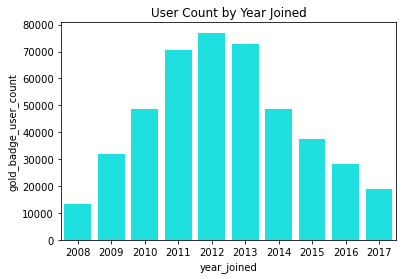

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.barplot(data = result, x = 'year_joined', y = 'gold_badge_user_count', color = 'cyan')
plot.set_title('User Count by Year Joined')

Unintendedly, we have a normal distribution of users joined by year.  
% of active gold badge users in 2020?